In [1]:
from __future__ import print_function, division
%run ../prereq/basics.ipynb

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Loading BokehJS ...

Using Theano backend.


In [2]:
df_tags = pd.read_csv('../coursera/data/ds_urls_shortnames_concepts_reviewed_2016_06_21.csv', encoding='utf-8')
print('len:', len(df_tags))
print('tags count:', df_tags['concept_tag'].count())
df_tags.head(2)

len: 940
tags count: 940


,id,course_shortname,url,concept_tag
0,ud257,ab-testing,https://www.udacity.com/course/ab-testing--ud2...,video_lecture
1,ud257,ab-testing,https://www.udacity.com/course/ab-testing--ud2...,in_depth


In [3]:
df = pd.read_csv('../coursera/data/learning_resource_table_2016_07_05.csv')
print('len:', len(df))
df.head(2)

len: 357


,id,title,subtitle,description,short_description,syllabus,url,slug,difficulty,created,...,available,end_date,typical_learning_time,rating,price,new,language,format,license,venue
0,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,###Lesson 1: How to Get Started\n\n- Interview...,https://www.udacity.com/course/intro-to-comput...,intro-to-computer-science--cs101,beginner,NaN,...,NaN,NaN,3months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity
1,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,### Lesson 1: Overview of A/B Testing\nThis le...,https://www.udacity.com/course/ab-testing--ud2...,ab-testing--ud257,intermediate,NaN,...,NaN,NaN,1months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity


In [4]:
df = pd.merge(df_tags, df, on='id', how='outer').groupby(by='id', as_index=False)
merged_df = pd.DataFrame(df.apply(lambda x: x.iloc[0]))
merged_df['tags'] = df.apply(lambda x: map(str, list(x['concept_tag'].values)))
print('len:', len(merged_df))
merged_df.head(2)

len: 357


,id,course_shortname,url_x,concept_tag,title,subtitle,description,short_description,syllabus,url_y,...,end_date,typical_learning_time,rating,price,new,language,format,license,venue,tags
0,-4ffSHNYEeWIfhKr_WcYsQ,reproducible-res,http://www.coursera.org/learn/reproducible-res...,reproducibility,Reproducible Research,NaN,This course focuses on the concepts and tools ...,NaN,NaN,http://www.coursera.org/learn/reproducible-res...,...,NaN,4-9 hours/week,NaN,Free,NaN,en,MOOC,Coursera specific license,Coursera,"[reproducibility, project, R, in_depth, video_..."
1,-N44X0IJEeWpogr5ZO8qxQ,ml-clust-retrieve,http://www.coursera.org/learn/ml-clustering-an...,natural_language_processing,Machine Learning: Clustering & Retrieval,NaN,Case Studies: Finding Similar Documents\n\nA r...,NaN,NaN,http://www.coursera.org/learn/ml-clustering-an...,...,NaN,NaN,NaN,Free,NaN,en,MOOC,Coursera specific license,Coursera,"[natural_language_processing, text_data, high_..."


In [5]:
merged_df.columns

Index([                   u'id',      u'course_shortname',
                       u'url_x',           u'concept_tag',
                       u'title',              u'subtitle',
                 u'description',     u'short_description',
                    u'syllabus',                 u'url_y',
                        u'slug',            u'difficulty',
                     u'created',         u'date_modified',
              u'date_published',             u'available',
                    u'end_date', u'typical_learning_time',
                      u'rating',                 u'price',
                         u'new',              u'language',
                      u'format',               u'license',
                       u'venue',                  u'tags'],
      dtype='object')

In [6]:
df = merged_df
#df['all-text'] = df['title'] + ' ' + df['subtitle'] + ' ' + df['description'] + ' ' + df['short_description'] + ' ' + df['syllabus']
cols = ['title', 'description', 'syllabus']
df['all-text'] = ''
for i in cols:
    df['all-text'] += df[i].astype('str')
    df['all-text'] += ' '
df['all-text'].tail(10)

347    Neural Networks for Machine Learning Learn abo...
348    Statistical Reasoning for Public Health 1: Est...
349    Mining Massive Datasets This class teaches alg...
350    Artificial Intelligence Planning The course ai...
351    Computational Methods for Data Analysis <div>E...
352    Relational Database Support for Data Warehouse...
353    Marketing Analytics Organizations large and sm...
354    People Analytics People analytics is a data-dr...
355    Data Warehouse Concepts, Design, and Data Inte...
356    Data Manipulation at Scale: Systems and Algori...
Name: all-text, dtype: object

In [7]:
df['all-text'] = df['all-text'].apply(text_cleanup).apply(text_cleanup)
df.to_pickle('coursera_with_tags.df')

In [8]:
df['all-text'].tail(10)

347    neural networks for machine learning learn abo...
348    statistical reasoning for public health estima...
349    mining massive datasets this class teaches alg...
350    artificial intelligence planning the course ai...
351    computational methods for data analysis div ex...
352    relational database support for data warehouse...
353    marketing analytics organizations large and sm...
354    people analytics people analytics is a data dr...
355    data warehouse concepts design and data integr...
356    data manipulation at scale systems and algorit...
Name: all-text, dtype: object

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6, min_df=2, ngram_range=(1, 3))
vectorized_text = vectorizer.fit_transform(df['all-text'].values)
from sklearn.decomposition import TruncatedSVD
if False:
    svd = TruncatedSVD(n_components=500, n_iter=100)
    vectorized_text = svd.fit_transform(vectorized_text)
else:
    vectorized_text = np.array(vectorized_text.todense())
print(type(vectorized_text))
print(vectorized_text.shape)
print(len(vectorized_text.shape))

<type 'numpy.ndarray'>
(357, 4811)
2


In [10]:
from collections import Counter
from operator import itemgetter

def quantify_clusters(plot_df):
    top_n_tags = 5
    
    g_df = pd.pivot_table(plot_df, index='y_bin', columns='x_bin', values='tags', aggfunc='count')
    sns.heatmap(g_df)
    plt.show()

    res_data = list()
    for n_tags in range(1, 20):
        def aggfunc(tags):
            if len(tags) > 1:
                sorted_tags, tags_counts = zip(*sorted(Counter([i for j in tags for i in j]).iteritems(), key=itemgetter(1)))
                sorted_tags = set(sorted_tags[-n_tags:])
                # tp / (tp + fp)
                tp = sum((i in t for t in tags for i in sorted_tags))
                fp = sum((i not in t for t in tags for i in sorted_tags))
                return tp / (tp + fp)
            else:
                return np.nan

        g_df = pd.pivot_table(plot_df, index='y_bin', columns='x_bin', values='tags', aggfunc=aggfunc)
        tsne_mean = np.nanmean(g_df.values.ravel())
        if n_tags == top_n_tags:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
            print('tsne mean:', tsne_mean)
            sns.heatmap(g_df, ax=ax1)

        rnd_df = plot_df.copy()
        tags_list = plot_df['tags'].values.tolist()
        random.shuffle(tags_list)
        rnd_df['tags'] = tags_list
        g_df = pd.pivot_table(rnd_df, index='y_bin', columns='x_bin', values='tags', aggfunc= aggfunc)
        rnd_mean = np.nanmean(g_df.values.ravel())
        if n_tags == top_n_tags:
            print('rnd mean:', rnd_mean)
            sns.heatmap(g_df, ax=ax2)
            plt.show()
        res_data.append((n_tags, tsne_mean, rnd_mean))
    pd.DataFrame(columns=['#tags', 'tsne', 'rnd'], data=res_data).plot(x='#tags')
    plt.show()

In [11]:
from mvpa2.suite import *

In [12]:
#dim_range = 25
n_bins = 15
som = SimpleSOMMapper((n_bins, n_bins), 1, learning_rate=1)
# n_rows, n_columns = dim_range, dim_range
# som = somoclu.Somoclu(n_columns, n_rows, data=vectorized_text.todense())
# som.train()

In [13]:
#som.view_umatrix(bestmatches=True, labels=df['title'])
som.train(vectorized_text)

In [14]:
binned_data = som(vectorized_text)

In [15]:
table = pd.DataFrame(columns=['x', 'y'], data=binned_data)
table['dummy'] = 1
table['title'] = df['title']
grp_table = table.groupby(by=('x', 'y'))
plot_table = pd.DataFrame(columns=['count'], data=grp_table.apply(lambda x: x['dummy'].sum()))
plot_table['titles'] = grp_table.apply(lambda x: ' || '.join([i[:60] for i in x['title'].values]))
plot_table = plot_table.reset_index()
plot_table.head(2)

,x,y,count,titles
0,4,10,57,Advances in Structured Prediction - VideoLectu...
1,5,9,51,Recommender Problems for Web Applications - Vi...


In [16]:
from bokeh.models import *
from bokeh.charts import HeatMap
from math import floor 

from bokeh.plotting import figure, output_file, show 
from bokeh.models import HoverTool, ColumnDataSource 
from bokeh.palettes import RdYlBu11 as palette 
warnings.filterwarnings('ignore')

x = plot_table['x']
y = plot_table['y']
c = plot_table['count']
t = plot_table['titles']
data = {'x':x, 'y':y, 'count':c, 'titles':t} 

# colormap by hand for now, a one-liner some day 
N, min, max = len(palette), c.min(), c.max() 
data['color'] = [] 
for x in data['count']: 
    ind = int(floor((x-min)/(max-min)*(N-1)))
    data['color'].append(palette[ind]) 

source = ColumnDataSource(data) 

hover = HoverTool( 
    #tooltips=[("description", "@titles"), ('count', '@count')] 
    tooltips = """
            <div>
                <span style="font-size: 10px; width: 200px; display: block;">@titles</span>
            </div>
            """
) 

hm = figure(title='test data', tools=[hover,"pan","box_zoom","wheel_zoom","reset","resize","save"]) 
hm.rect(x='x', y='y', width=1, height=1, fill_color='color', line_color="white", source=source)
show(hm)

In [17]:
plot_df = pd.DataFrame(columns=['x_bin', 'y_bin'], data=binned_data)
plot_df['title'] = df['title']
plot_df['tags'] = df['tags']
plot_df = plot_df[plot_df['tags'].apply(lambda x: x[0] != 'nan')]
plot_df['tags'] = plot_df['tags'].apply(lambda x: list(map(lambda i: i.lower(), x)))
tag_dist = list()
for t in set([i for t in plot_df['tags'] for i in t]):
    tag_dist.append((t, plot_df['tags'].apply(lambda x: t in x).sum()/len(plot_df)))
tag_dist = pd.DataFrame(data=tag_dist, columns=['tag', 'occurence']).sort_values(by='occurence')
tag_dist.tail(10)

,tag,occurence
43,python,0.141892
51,machine_learning,0.148649
70,data_visualization,0.182432
46,business_analytics,0.236486
67,project,0.297297
71,overview,0.324324
33,probability_statistics,0.398649
18,in_depth,0.567568
50,video_lecture,0.993243
20,mooc,1.000000


In [18]:
filt_tags = set(['mooc', 'video_lecture', 'in_depth'])
plot_df['tags'] = plot_df['tags'].apply(lambda x: list(set(list(filter(lambda i: i not in filt_tags, x)))))
plot_df['tags'].head(2)

0                        [project, reproducibility, r]
1    [clustering, high_performance_computing, pytho...
Name: tags, dtype: object

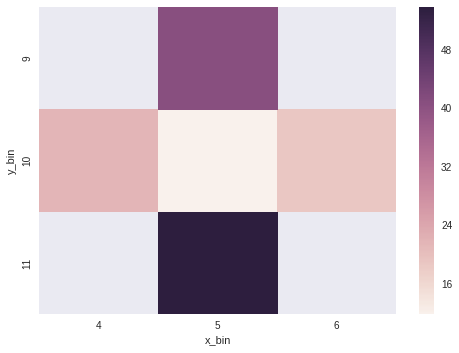

tsne mean: 0.308808106741
rnd mean: 0.294781922779


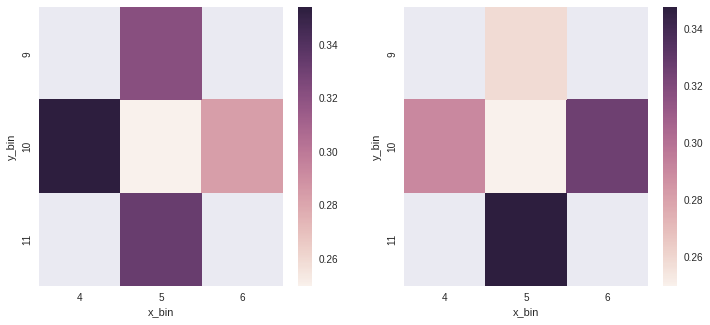

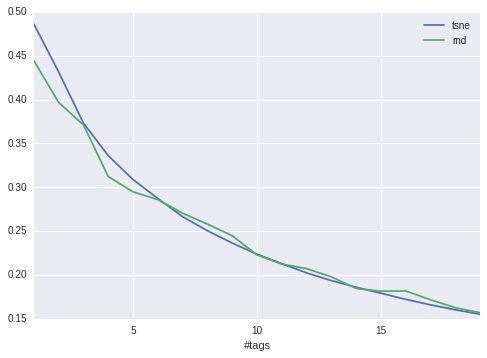

In [19]:
quantify_clusters(plot_df)

In [20]:
f_names = np.array(vectorizer.get_feature_names())
tags = f_names[vectorized_text.argmax(axis=1)]
#print('tags:', tags)
print(len(tags))

357


In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=500, n_iter=1000000, random_state=2016)

In [22]:
tsne_text = tsne.fit_transform(vectorized_text)

In [23]:
from bokeh.charts import Scatter

In [24]:
plot_df = pd.DataFrame(columns=['x', 'y'], data=tsne_text)
plot_df['title'] = df['title']
plot_df['tags'] = df['tags']
print(len(plot_df))
#plot_df = plot_df[plot_df['tags'].apply(lambda x: x[0] != 'nan')]
#print(len(plot_df))

357


In [25]:
hover = HoverTool(
    tooltips=[("x", "@x"), ("x", "@y"), ("Titles", "@title")]
)

source = ColumnDataSource(plot_df)
p = figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
# Add the hover tool
p.add_tools(hover)

# Populate glyphs
p.circle(x='x', y='y', size=7, alpha=0.5, source=source)
#p = Scatter(plot_df, title="scat", width=800, tools=[hover, "pan","box_zoom","wheel_zoom","reset","resize","save"])
show(p)

In [26]:
plot_df.head(2)

,x,y,title,tags
0,1.800963,2.627165,Reproducible Research,"[reproducibility, project, R, in_depth, video_..."
1,6.857625,-3.449482,Machine Learning: Clustering & Retrieval,"[natural_language_processing, text_data, high_..."


In [27]:
x_bins = np.linspace(plot_df['x'].min(), plot_df['x'].max(), n_bins)
plot_df['x_bin'] = np.digitize(plot_df['x'], x_bins)

x_bins = np.linspace(plot_df['y'].min(), plot_df['y'].max(), n_bins)
plot_df['y_bin'] = np.digitize(plot_df['y'], x_bins)
plot_df['y_bin'] *= -1
plot_df.head(5)

,x,y,title,tags,x_bin,y_bin
0,1.800963,2.627165,Reproducible Research,"[reproducibility, project, R, in_depth, video_...",10,-9
1,6.857625,-3.449482,Machine Learning: Clustering & Retrieval,"[natural_language_processing, text_data, high_...",12,-6
2,5.088129,10.041852,Introduction to Genomic Technologies,"[video_lecture, project, genomic_data, genetic...",11,-13
3,-15.321481,-4.115538,Deep Learning for Machine Vision - VideoLectur...,[nan],2,-6
4,-12.033580,2.453155,Introduction to Machine Learning - VideoLectur...,[nan],4,-9


In [28]:
print(len(plot_df))
plot_df = plot_df[plot_df['tags'].apply(lambda x: x[0] != 'nan')]
plot_df['tags'] = plot_df['tags'].apply(lambda x: list(map(lambda i: i.lower(), x)))
print(len(plot_df))

357
148


In [29]:
plot_df['tags'] = plot_df['tags'].apply(lambda x: list(set(list(filter(lambda i: i not in filt_tags, x)))))
plot_df['tags'].head(2)

0                        [project, reproducibility, r]
1    [clustering, high_performance_computing, pytho...
Name: tags, dtype: object

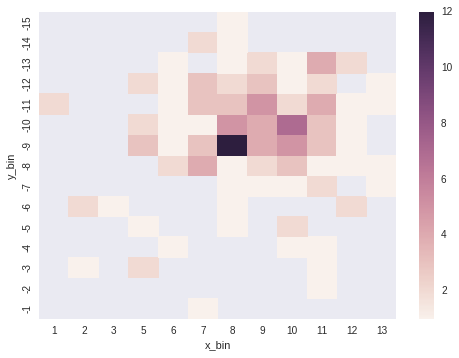

tsne mean: 0.586646258503
rnd mean: 0.485714285714


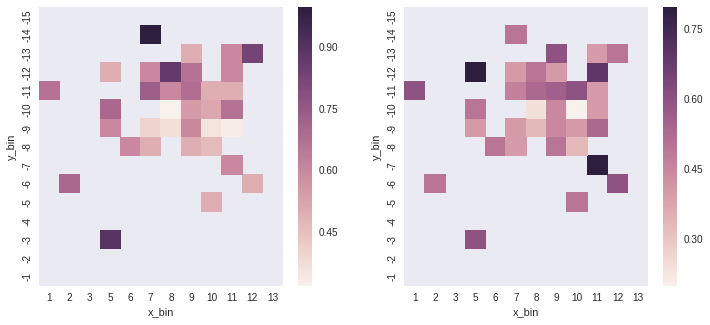

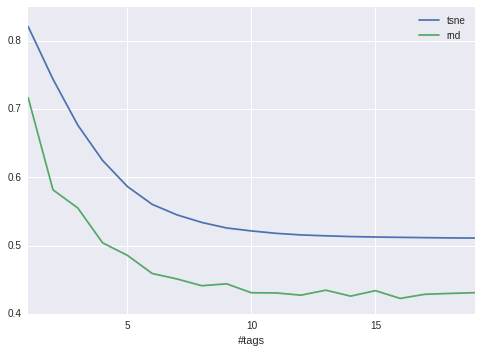

In [30]:
quantify_clusters(plot_df)

In [31]:
cols = ['title', 'description', 'syllabus']
plot_df['vectext'] = plot_df['tags'].apply(lambda x: ' '.join(x))
plot_df.head(2)

,x,y,title,tags,x_bin,y_bin,vectext
0,1.800963,2.627165,Reproducible Research,"[project, reproducibility, r]",10,-9,project reproducibility r
1,6.857625,-3.449482,Machine Learning: Clustering & Retrieval,"[clustering, high_performance_computing, pytho...",12,-6,clustering high_performance_computing python h...


In [32]:
vectorizer = TfidfVectorizer(stop_words='english', tokenizer=None, max_df=0.9, min_df=2)
vectorized_text = vectorizer.fit_transform(plot_df['vectext'].values)
print(vectorized_text.shape)
print(len(set([i for t in plot_df['tags'].values for i in t])))

(148, 50)
71


In [33]:
tsne = TSNE(n_components=2, learning_rate=500, n_iter=1000000, random_state=2016)
plot_df[['x', 'y']] = tsne.fit_transform(vectorized_text.toarray())

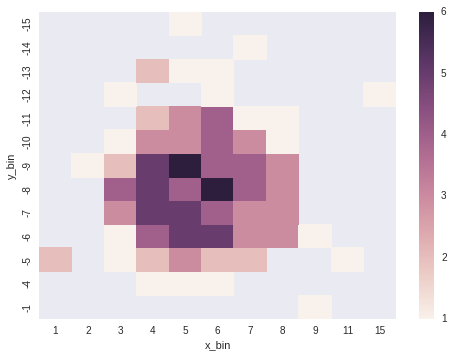

In [34]:
x_bins = np.linspace(plot_df['x'].min(), plot_df['x'].max(), n_bins)
plot_df['x_bin'] = np.digitize(plot_df['x'], x_bins)

x_bins = np.linspace(plot_df['y'].min(), plot_df['y'].max(), n_bins)
plot_df['y_bin'] = np.digitize(plot_df['y'], x_bins)
plot_df['y_bin'] *= -1

g_df = pd.pivot_table(plot_df, index='y_bin', columns='x_bin', values='tags', aggfunc='count')
sns.heatmap(g_df)
plt.show()

#g_df = pd.pivot_table(plot_df, index='y_bin', columns='x_bin', values='tags', aggfunc=aggfunc)
#print('tsne mean:', np.nanmean(g_df.values.ravel()))
#sns.heatmap(g_df)
#plt.show()

In [35]:
hover = HoverTool(
    tooltips=[("x", "@x"), ("x", "@y"), ("Titles", "@vectext")]
)

source = ColumnDataSource(plot_df)
p = figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
# Add the hover tool
p.add_tools(hover)

# Populate glyphs
p.circle(x='x', y='y', size=7, alpha=0.5, source=source)
#p = Scatter(plot_df, title="scat", width=800, tools=[hover, "pan","box_zoom","wheel_zoom","reset","resize","save"])
show(p)

In [36]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6, min_df=5, ngram_range=(1 ,3))
text = df['all-text']
tfidf = vectorizer.fit_transform(text.values)
tfidf, words = filter_word_rep(tfidf, vectorizer.get_feature_names())
print(tfidf.shape)

(357, 1191)


In [51]:
from sklearn.decomposition import NMF
n_topics = 30
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

feature_names = words
n_top_words = 10
topic_dict = dict()
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    topic_top_words = ", ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(topic_top_words)
    topic_dict[topic_idx] = topic_top_words
    print()

Topic #0:
big, big data, data, hadoop, security, tools, tutorial, scientists, data scientists, available

Topic #1:
machine, machine learning, learning, statistical machine learning, statistical machine, introduction machine, introduction machine learning, science, learning algorithms, algorithms

Topic #2:
deep, deep learning, learning, nlp, faster, people, theoretical, speech, speech recognition, recognition

Topic #3:
graphical models, graphical, models, probabilistic, probabilistic graphical models, probabilistic graphical, message, introduction, basics, structured prediction

Topic #4:
clustering, objects, means, cluster, algorithms, discuss, algorithm, approximation, popular, similar

Topic #5:
reinforcement learning, reinforcement, learning, function, approximation, rl, policy, approaches, planning, agent

Topic #6:
mining, data mining, data, pattern, discovery, knowledge, applications, patterns, tutorial, semantic

Topic #7:
networks, neural, neural networks, deep, nlp, trainin

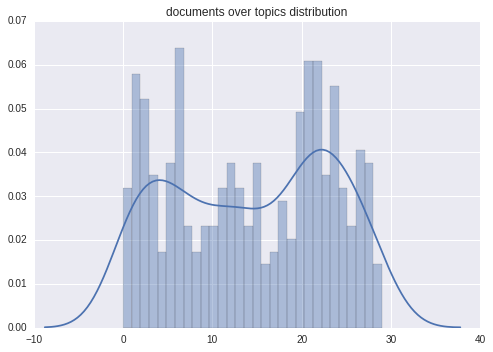


--------------------------------------------------------------------------------
machine learning with knowledge graphs most successful applications of statistical machine learning focus on response learning or signal reaction learning where an output is produced as a direct response to an input an important feature is a quick response time the basis for e g real time ad placement on the web real time address reading in postal automation or a fast reaction to threats for a bio
topic id: 1
machine, machine learning, learning, statistical machine learning, statistical machine, introduction machine, introduction machine learning, science, learning algorithms, algorithms

--------------------------------------------------------------------------------
graph analytics for big data want to understand your data network structure and how it changes under different conditions curious to know how to identify closely interacting clusters within a graph have you heard of the fast growing area of 

In [52]:
transformed = nmf.transform(tfidf)
sns.distplot(transformed.argmax(axis=1).flatten(), bins=n_topics)
plt.title('documents over topics distribution')
plt.show()
#most_freq_topic = max(Counter(transformed.argmax(axis=1).flatten()).items(), key=itemgetter(1))[0]
#print('most freq. topic:', most_freq_topic)
#topic_range = np.array(filter(lambda x: x!= most_freq_topic, range(transformed.shape[1])))
#print(topic_range)
#sns.distplot(transformed[:, topic_range].argmax(axis=1).flatten())
#plt.show()
for i in np.random.choice(range(len(text)), size=10):
    print()
    print('-'*80)
    print(text.iloc[i][:400])
    comp_prob = nmf.transform(tfidf[i, :])[:, :].argmax(axis=1)[0]
    print('topic id:', comp_prob)
    print(topic_dict[comp_prob])  

In [39]:
df['topic'] = transformed.argmax(axis=1)
df.head(2)

,id,course_shortname,url_x,concept_tag,title,subtitle,description,short_description,syllabus,url_y,...,rating,price,new,language,format,license,venue,tags,all-text,topic
0,-4ffSHNYEeWIfhKr_WcYsQ,reproducible-res,http://www.coursera.org/learn/reproducible-res...,reproducibility,Reproducible Research,NaN,This course focuses on the concepts and tools ...,NaN,NaN,http://www.coursera.org/learn/reproducible-res...,...,NaN,Free,NaN,en,MOOC,Coursera specific license,Coursera,"[reproducibility, project, R, in_depth, video_...",reproducible research this course focuses on t...,21
1,-N44X0IJEeWpogr5ZO8qxQ,ml-clust-retrieve,http://www.coursera.org/learn/ml-clustering-an...,natural_language_processing,Machine Learning: Clustering & Retrieval,NaN,Case Studies: Finding Similar Documents\n\nA r...,NaN,NaN,http://www.coursera.org/learn/ml-clustering-an...,...,NaN,Free,NaN,en,MOOC,Coursera specific license,Coursera,"[natural_language_processing, text_data, high_...",machine learning clustering retrieval case stu...,14


In [40]:
topic_tags = df.groupby(by='topic').apply(lambda x: Counter(j for i in x['tags'] for j in i if j != 'nan'))
topic_tags.head(2)

topic
0    {u'graph_data': 1, u'MOOC': 5, u'genetics': 1,...
1    {u'high_performance_computing': 1, u'text_data...
dtype: object

In [41]:
topic_tags = topic_tags.apply(lambda x: sorted(x.items(), key=itemgetter(1), reverse=True)[:5])

In [42]:
from bokeh.charts import Scatter
from bokeh.models import HoverTool, ColumnDataSource 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=500, n_iter=1000000, random_state=2016)
tsne_text = tsne.fit_transform(transformed) # [n_samples, n_features]
plot_df = pd.DataFrame(columns=['x', 'y'], data=tsne_text)
plot_df['title'] = df['title'].apply(lambda x: x.replace('- VideoLectures.NET', "")) # add info for hovering
plot_df['tags'] = df['tags'].copy()
#plot_df = plot_df[plot_df['tags'].apply(lambda x: x[0] != 'nan')]
print(len(plot_df))
hover = HoverTool(
    tooltips=[("T", "@title")]
)

source = ColumnDataSource(plot_df)
p = figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
# Add the hover tool
p.add_tools(hover)

# Populate glyphs
p.circle(x='x', y='y', size=7, alpha=0.5, source=source)
#p = Scatter(plot_df, title="scat", width=800, tools=[hover, "pan","box_zoom","wheel_zoom","reset","resize","save"])
show(p)

357


In [43]:
n_bins = 10
x_bins = np.linspace(plot_df['x'].min(), plot_df['x'].max(), n_bins)
plot_df['x_bin'] = np.digitize(plot_df['x'], x_bins)

x_bins = np.linspace(plot_df['y'].min(), plot_df['y'].max(), n_bins)
plot_df['y_bin'] = np.digitize(plot_df['y'], x_bins)
plot_df['y_bin'] *= -1
plot_df.head(5)

,x,y,title,tags,x_bin,y_bin
0,5.044048,12.224447,Reproducible Research,"[reproducibility, project, R, in_depth, video_...",6,-8
1,0.137974,9.677910,Machine Learning: Clustering & Retrieval,"[natural_language_processing, text_data, high_...",5,-7
2,-8.216634,-9.869890,Introduction to Genomic Technologies,"[video_lecture, project, genomic_data, genetic...",2,-2
3,-0.683018,-12.298592,Deep Learning for Machine Vision,[nan],5,-1
4,8.779767,3.023266,Introduction to Machine Learning,[nan],7,-5


In [44]:
print(len(plot_df))
plot_df = plot_df[plot_df['tags'].apply(lambda x: x[0] != 'nan')]
plot_df['tags'] = plot_df['tags'].apply(lambda x: list(map(lambda i: i.lower(), x)))
print(len(plot_df))

357
148


In [45]:
filt_tags = set(['mooc', 'video_lecture', 'in_depth'])
tags_occ = Counter(j for i in plot_df['tags'] for j in i)
filt_tags.update(set(key for key, val in tags_occ.items() if val < 3))
print(filt_tags)
plot_df['tags'] = plot_df['tags'].apply(lambda x: list(set(list(filter(lambda i: i not in filt_tags, x)))))
plot_df['tags'].head(2)

set(['nosql', 'graph_database', 'ensemble_learning', 'engineering', 'topic_model', 'image_data', 'galaxy', 'in_depth', 'xml', 'mooc', 'java', 'information_retrieval', 'dimensionality_reduction', 'streaming_data', 'json', 'html', 'matlab', 'mobile_devices', 'mathematics', 'fmri', 'biology', 'time_series_data', 'kernel_methods', 'video_lecture', 'gis', 'ethics', 'probabilistic_graphical_model', 'parallel_database', 'linear_algebra', 'economics', 'physics', 'history'])


0                        [project, reproducibility, r]
1    [clustering, high_performance_computing, pytho...
Name: tags, dtype: object

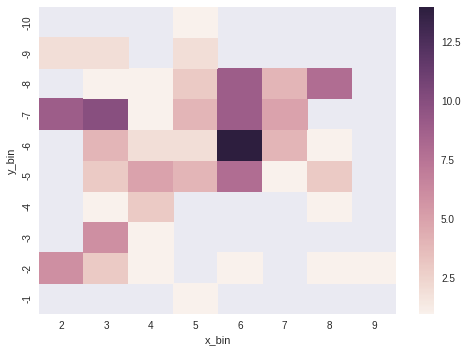

tsne mean: 0.513836996337
rnd mean: 0.406593406593


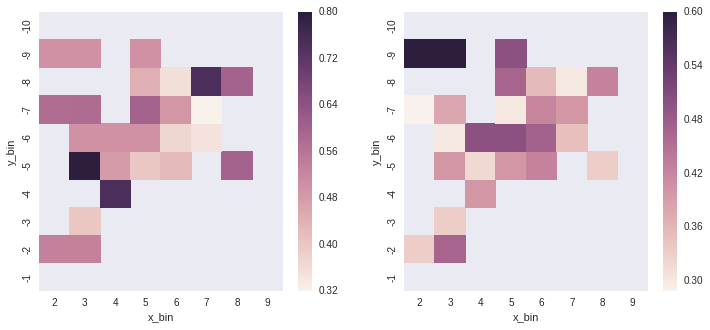

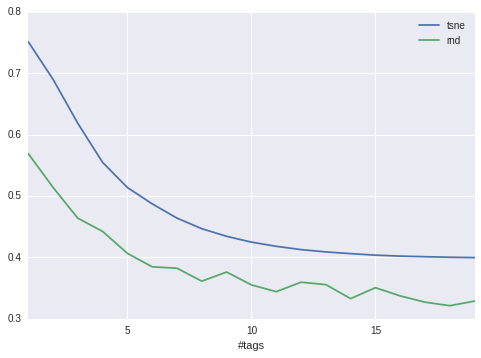

In [46]:
quantify_clusters(plot_df)

In [47]:
tags_occ = Counter(j for i in plot_df['tags'] for j in i)

In [48]:
len(tags_occ)

42

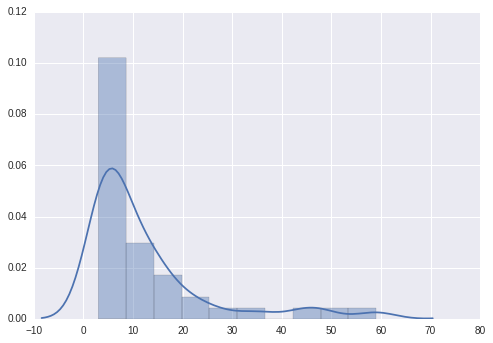

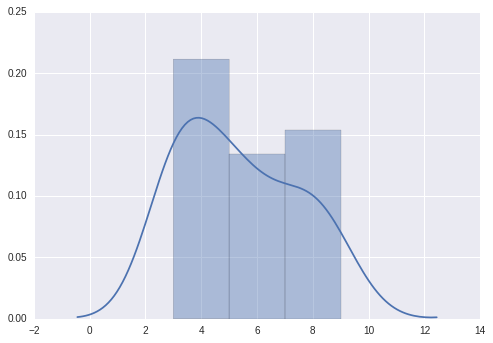

[('probability_statistics', 59), ('overview', 48), ('project', 44), ('business_analytics', 35), ('data_visualization', 27), ('machine_learning', 22), ('python', 21), ('data_collection', 18), ('big_data', 16), ('project_focused', 15), ('r', 15), ('regression', 13), ('hadoop', 13), ('case_study', 13), ('data_integration', 12), ('text_data', 12), ('relational_database', 9), ('graph_analytics', 9), ('genetics', 8), ('healthcare', 8)]


In [49]:
sorted_tags = sorted(tags_occ.items(), key=itemgetter(1), reverse=True)
sns.distplot(zip(*sorted_tags)[1])
plt.show()
sns.distplot(list(filter(lambda x: x < 10, zip(*sorted_tags)[1])))
plt.show()
print(sorted_tags[:20])

22


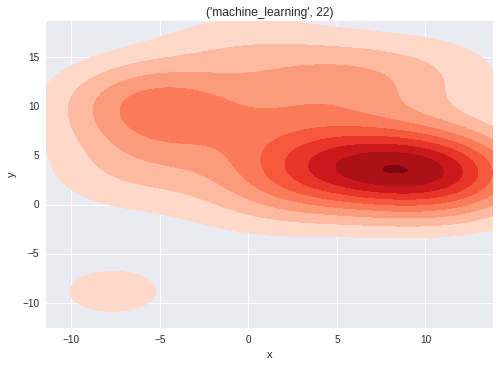

21


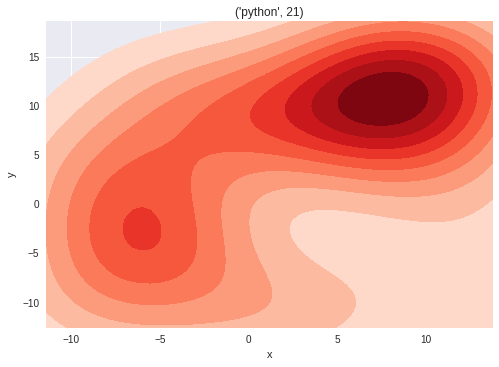

18


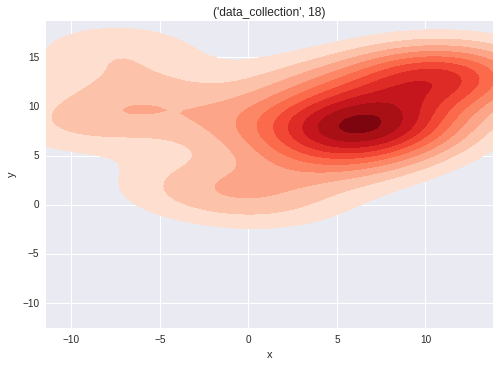

16


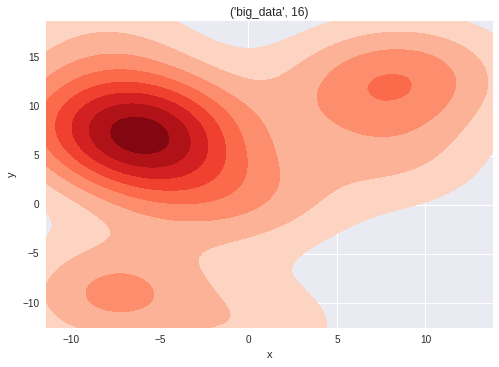

15


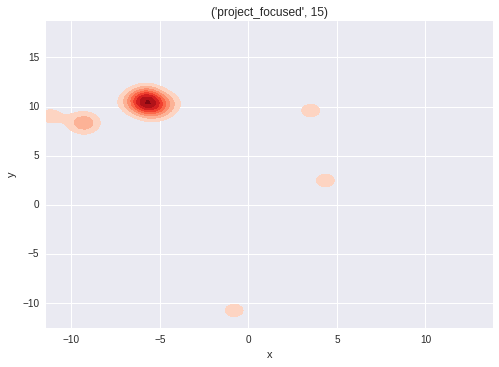

15


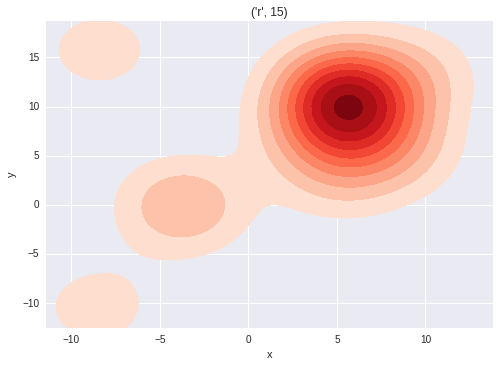

13


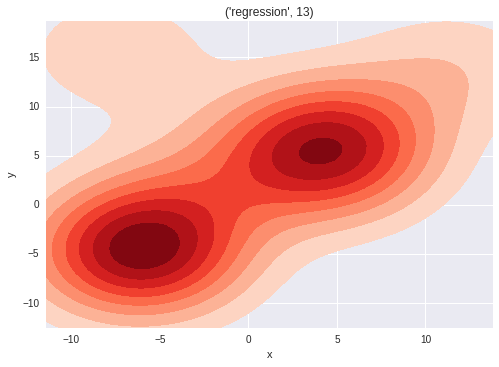

13


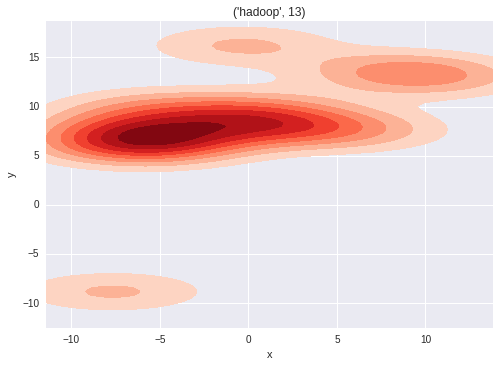

13


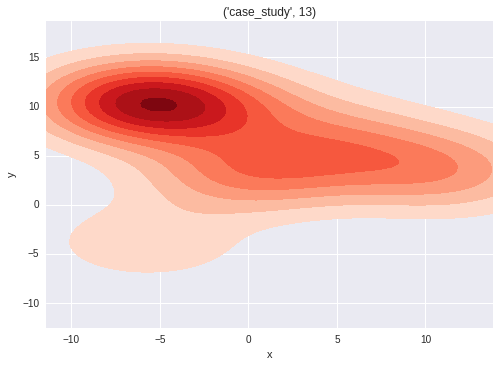

12


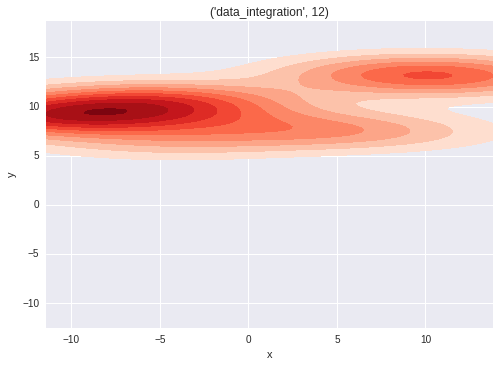

12


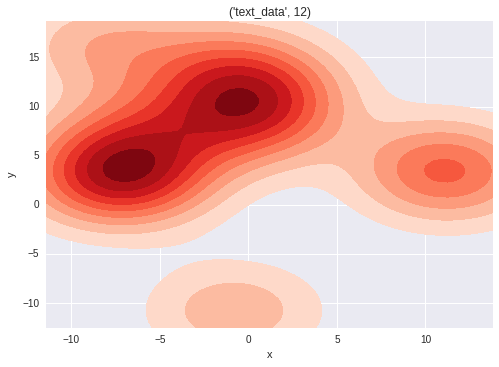

9


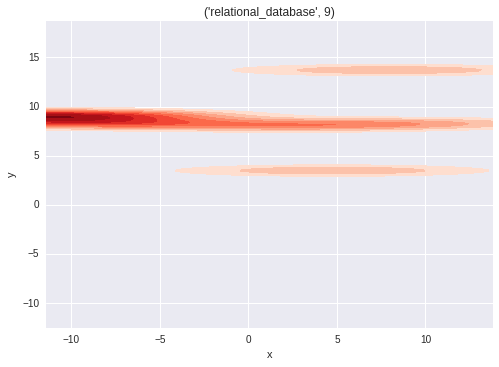

9


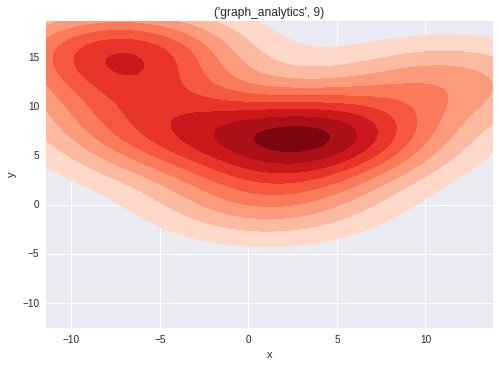

8


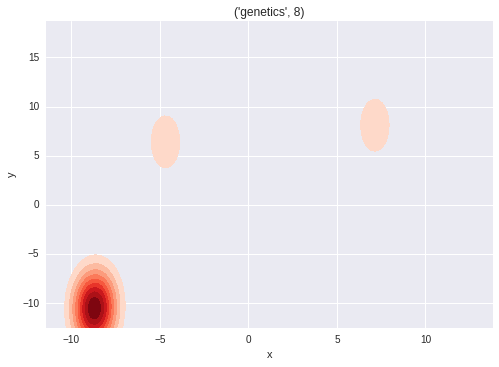

8


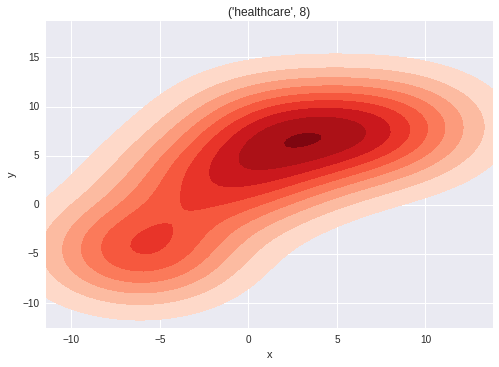

8


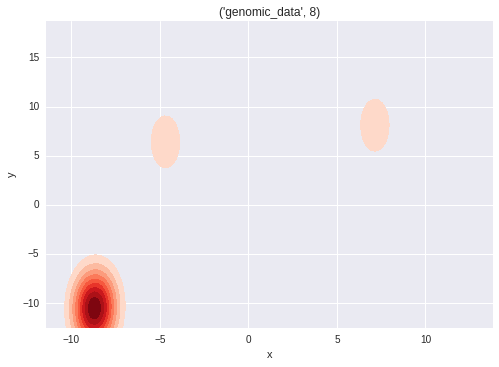

8


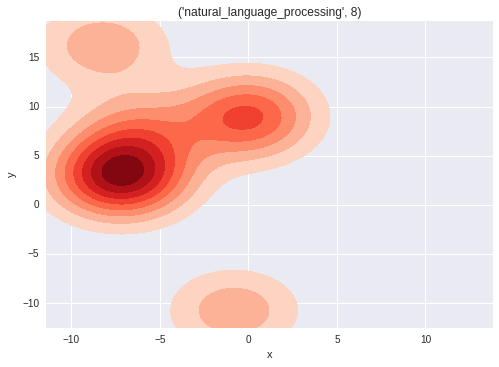

7


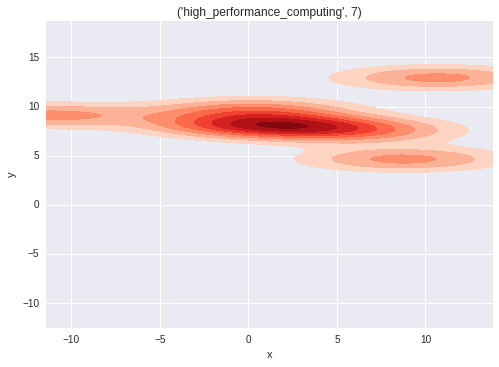

7


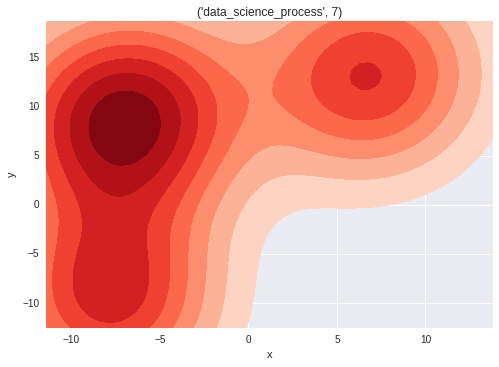

6


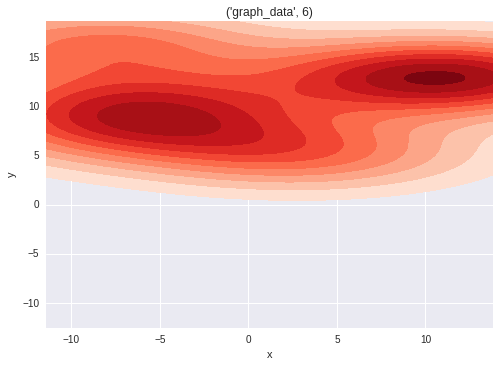

6


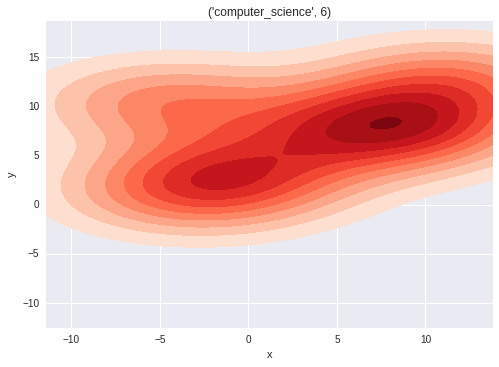

6


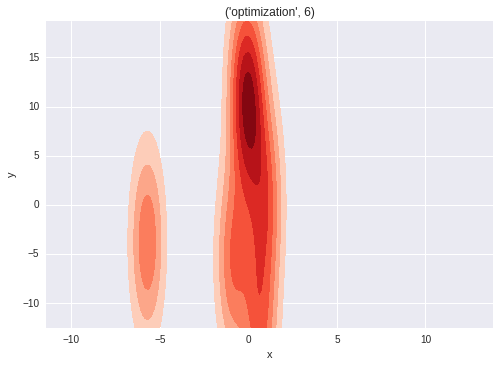

5


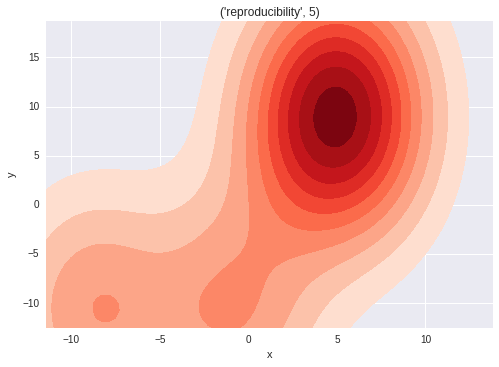

5


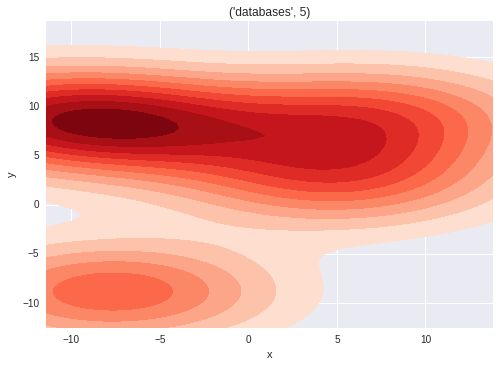

5


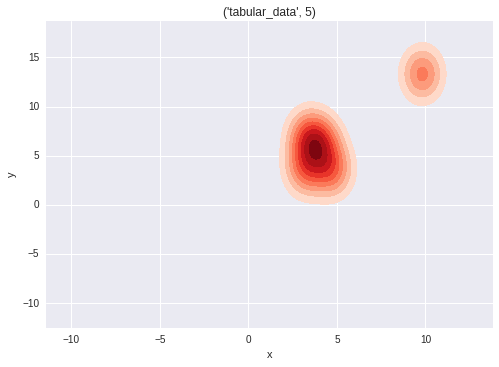

In [50]:
x_lim = [plot_df['x'].min(), plot_df['x'].max()]
y_lim = [plot_df['y'].min(), plot_df['y'].max()]
for i in sorted_tags[5:30]:
    t, occ = i
    t_df = plot_df[plot_df['tags'].apply(lambda x: t in x)]
    print(len(t_df))
    ax = sns.kdeplot(t_df['x'], t_df['y'],
                 cmap="Reds", shade=True, shade_lowest=False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    plt.title(i)
    plt.show()